# Path pattern generation using an Evolutionary computing aproach

in this module we will explore on how we can generate a valid sequence based on genetic and evolutionary computing.

## Table of Contents

1. [Libraries](#Libraries)
2. [Fetching data](#Fetch-preprocessed-data)
3. [Sample data](#Sample-black-pixels)
    1. [Change resolution](#Change-resolution)
    2. [Initializing the Sequence](#Initialize-the-sequence-of-the-black-pixels)
4. [Configurations, Parameters and Constants](#Configurations,-Parameters-and-Constants)
5. [Genetics Algorithm general model and template](#Genetic-algorithm-general-model-template)
6. [Functions and Behaviors](#Functions-and-behaviors)
    1. [Mutations](#Mutations)
        1. `insert_mutation`
        1. `scramble_mutation`
        1. `inversion_mutation`
        1. `swap_mutation`
    2. [Recombinations](#Recombinations)
        1. `order1_crossover`
        1. `partially_mapped_crossover`
        1. `cycle_crossover`
        1. `edge_recombination`
    3. [SSGA Selections](#Selections(SSGA))
        1. [Parent Selection](#Parent-Selection)
        2. [Survival Selection](#Survival-Selection)
            1. `random_population_select`
            1. `best_population_select`
            1. `fitness_porportionate_select`
            1. `linear_ranked_based_select`
            1. `exponential_ranked_based_select`
    4. [Population control functions](#MISC-and-population-related)
7. [Testing Functions](#Testing)
8. [Path generation training](#Training-path-generating)

## Libraries

In [1]:
import random
import heapq
import numpy as np
import cv2 as cv
import ppg_init as ppg
import seqeval

DEBUGMODE = False

initialized data stored in the following directory:
/d/APh504/Bachelor/Semester 10/1.project/my_project/offline_processing


## Fetch preprocessed data

In [2]:
number_gray = np.zeros((ppg.NO_DIGITS, ppg.IMG_WIDTH ,ppg.IMG_HEIGHT))
for i in range (ppg.NO_DIGITS):
    number_image = cv.imread(ppg.IMAGE_PATH+' '+str(i)+' dilated.png')
    number_gray[i] = cv.cvtColor(number_image, cv.COLOR_BGR2GRAY)

## Sample black pixels

there are two ways to sample the pixels. sampling based on their distribution, sampling them based on their sufficient black pixel in a subarea of the image and uniformly distribute them. here we try both and compare the results.

### Change resolution


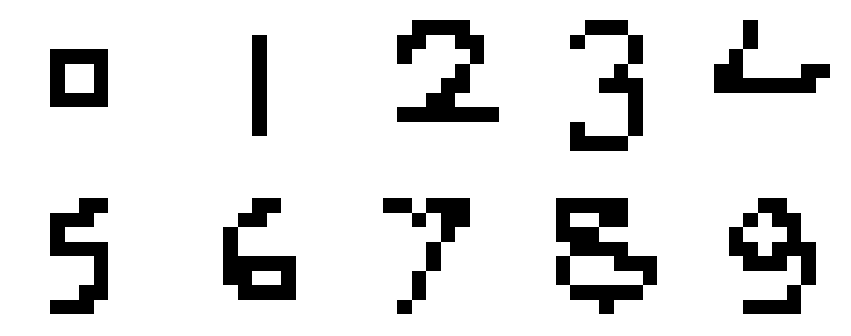

In [3]:
stride = 30
lrbp_threshold = 10 # low resolution black pixels threshold. 
# this is used when we want to count the number of the black pixels in the high resolution image
# and decide whether to mark the corresponding pixel in low resolution image black.
new_imgw = int(ppg.IMG_WIDTH/stride)
new_imgh = int(ppg.IMG_HEIGHT/stride)
new_img = np.ones((ppg.NO_DIGITS, new_imgw, new_imgh))*255
new_img2 = np.ones((ppg.NO_DIGITS, new_imgw, new_imgh))*255
# stride is always an odd number.

for i in range(ppg.NO_DIGITS):
    my_img = number_gray[i]
    # jump a 3,3 square and check for any black pixel within the area.

    for x in range(0, len(my_img), stride):
        for y in range(0, len(my_img[x]), stride):
            # stride is always an odd number.
            offset = int((stride-1)/2)
            new_x = int(x/stride)
            new_y = int(y/stride)
            black_pxl_vec = my_img[x-offset:x+offset+1,y-offset:y+offset+1]<50
            black_pxl_num = np.sum(black_pxl_vec)
#             print(has_black_pxl, end=' ')
            if(black_pxl_num>lrbp_threshold): # has at least one black pixel
                new_img[i,new_x,new_y] = 0
#         print(' ')
#     print('====================')
ppg.plot_digits(new_img)

### Initialize the sequence of the black pixels

In [4]:
sequence_num = []
for digit in range(10):
    sequence = []
    for row in range(len(new_img[digit])):
        for col in range(len(new_img[digit, row])):
            if new_img[digit, row, col]==0:
                sequence.append((row, col))
    sequence_num.append(sequence)
    if(DEBUGMODE):
        print('black pixels list for number ', digit, ':')
        print(sequence, '\n')
if(DEBUGMODE):
    print(sequence_num)

## Configurations, Parameters and Constants

In [5]:
P_MUTATION = 0.8
P_CROSSOVER = 1.0
POPULATION_SIZE = 100

DIGIT = 0

## Genetic algorithm general model template

In [6]:
# genetic algorithm general model template
def train_evolve(mutation,
                 crossover,
                 parent_sel, 
                 population_sel, 
                 population_init, 
                 population_terminate, 
                 fitness_func, 
                 geno2pheno,
                 get_parents_pair_method):
    population_heap = []
    population = population_init()
    generation = 0
    fitness_func.count = 0
    avg_fitness_profile = []
    best_fitness_profie = []
    while(population_terminate(population_heap, fitnessfunc.count, generation)):
        generation_fitness_profile = []
        best_fitness = 0
        for individual in population:
            ind_phenotype = geno2pheno(individual)
            fitness = fitness_func(ind_phenotype)
            generation_fitness_profile.append(fitness)
            if(fitness > best_fitness):
                best_fitness = fitness
            heappush(population_heap, (1/fitness, individual))
            
        selected_parents = parent_sel(population_heap)
        children = crossover(selected_parents, get_parents_pair_method)
        for child in children:
            mutation(child)
            child_phenotype = geno2pheno(individual)
            fitness = fitness_func(child_phenotype)
            if(fitness > best_fitness):
                best_fitness = fitness
            heappush(population_heap, (1/fitness, child))
        
        fitness_avg = np.average(generation_fitness_profile)
        avg_fitness_profile.append(fitness_avg)
        best_fitness_profile.append(best_fitness)
        generation_profile = list(range(generation))
        population = population_sel(population_heapm, POPULATION_SIZE)
        generation +=1
        # plot the diagrams and report

## Functions and behaviors

### Mutations

In [7]:
# mutations -----------------------------------
def insert_mutation(child):
    if(random.random() < P_MUTATION):
        left = random.randint(0,len(child)-1)
        right = random.randint(0,len(child)-1)
        print('left= ', left, 'right= ', right)
        while(left==right or right==left+1 or left==right+1):
            right = random.randint(0,len(child)-1)
        if(left>right):
            left,right = right,left
        child.insert(left+1, child[right])
        del child[right+1]
        print('left= ', left, 'right= ', right)
    else:
        print('mutation didn\'t occur')
    
def scramble_mutation(child):
    if(random.random() < P_MUTATION):
        left = random.randint(0,len(child)-1)
        right = random.randint(0,len(child)-1)
        print('left= ', left, 'right= ', right)
        while(left==right):
            right = random.randint(0,len(child)-1)
        if(left > right):
            left,right = right,left
        sublist = child[left:right+1]
        random.shuffle(sublist)
        child[left:right+1] = sublist
        print('left= ', left, 'right= ', right)
    else:
        print('mutation didn\'t occur')

def inversion_mutation(child):
    if(random.random() < P_MUTATION):
        left = random.randint(0,len(child)-1)
        right = random.randint(0,len(child)-1)
        while(left==right):
            right = random.randint(0,len(child)-1)
        if(left > right):
            left,right = right,left
        child[left:right+1] = child[left:right+1][::-1]
        print('left= ', left, 'right= ', right)
    else:
        print('mutation didn\'t occur')
        
def swap_mutation(child):
    if(random.random() < P_MUTATION):
        left = random.randint(0,len(child)-1)
        right = random.randint(0,len(child)-1)
        print('left= ', left, 'right= ', right)
        while(left==right):
            right = random.randint(0,len(child)-1)
        child[left],child[right] = child[right],child[left]
        print('left= ', left, 'right= ', right)
    else:
        print('mutation didn\'t occur')
# mutations -----------------------------------

### Recombinations

In [8]:
# duplicates are allowed, duplicate in one pair is also allowed.
def get_parents_pair_duplocal(sel_parents):
    sel_parents_lsize = len(sel_parents)
    new_list_size = len(sel_parents)//2
    parents_pairs = [(-1,-1)]*new_list_size
    for ctr in range(new_list_size):
        p_index1 = random.randint(0,sel_parents_lsize-1)
        p_index2 = random.randint(0,sel_parents_lsize-1)
        parents_pairs[ctr] = (sel_parents[p_index1], sel_parents[p_index2])
    return parents_pairs
        
# duplicates are allowed in pairs
def get_parents_pair_dupglobal(sel_parents):
    sel_parents_lsize = len(sel_parents)
    new_list_size = len(sel_parents)//2
    parents_pairs = [(-1,-1)]*new_list_size
    for ctr in range(new_list_size):
        p_index1 = random.randint(0,sel_parents_lsize-1)
        p_index2 = random.randint(0,sel_parents_lsize-1)
        while(p_index1==p_index2):
            p_index2 = random.randint(0,sel_parents_lsize-1)
        parents_pairs[ctr] = (sel_parents[p_index1], sel_parents[p_index2])
    return parents_pairs
        
# no duplicates are allowed in pairs
def get_parents_pair_nodup(sel_parents):
    sel_parents_lsize = len(sel_parents)
    new_list_size = len(sel_parents)//2
    parents_pairs = [(-1,-1)]*new_list_size
    selected = [-1]*len(sel_parents)
    for ctr in range(new_list_size):
        p_index1 = random.randint(0,sel_parents_lsize-1)
        while(p_index1 in selected):
            p_index1 = random.randint(0,sel_parents_lsize-1)
        
        selected[ctr*2] = p_index1
        
        p_index2 = random.randint(0,sel_parents_lsize-1)
        while(p_index2 in selected):
            p_index2 = random.randint(0,sel_parents_lsize-1)
        
        selected[ctr*2+1] = p_index2
        parents_pairs[ctr] = (sel_parents[p_index1], sel_parents[p_index2])
    return parents_pairs
        
# parents are allowed in multiple pairs but no pair is repeated
def get_parents_pair_uniqpair(sel_parents):
    sel_parents_lsize = len(sel_parents)
    new_list_size = len(sel_parents)//2
    parents_pairs = [(-1,-1)]*new_list_size
    index_pairs = [(-1,-1)]*new_list_size
    for ctr in range(new_list_size):
        p_index1 = random.randint(0,sel_parents_lsize-1)
        p_index2 = random.randint(0,sel_parents_lsize-1)
        while(p_index2==p_index1):
            p_index2 = random.randint(0,sel_parents_lsize-1)
        
        while(((p_index1, p_index2) in index_pairs) or ((p_index1, p_index2) in index_pairs)):
            p_index1 = random.randint(0,sel_parents_lsize-1)
            p_index2 = random.randint(0,sel_parents_lsize-1)
            while(p_index2==p_index1):
                p_index2 = random.randint(0,sel_parents_lsize-1)
            
        index_pairs[ctr] = (p_index1, p_index2)
        parents_pairs[ctr] = (sel_parents[p_index1], sel_parents[p_index2])
    if(DEBUGMODE):
        return parents_pairs, index_pairs
    else:
        return parents_pairs

# pairs the parents with the order recieved, e.g. index 0 with index 1, index 2 with index 3, so forth.
def get_parents_pair_prime_order(sel_parents):
    new_list_size = len(sel_parents)//2
    parents_pairs = [(-1,-1)]*new_list_size
    for ctr in range(new_list_size):
        parents_pairs[ctr] = (sel_parents[ctr*2], sel_parents[ctr*2+1])
    return parents_pairs
    
# crossovers ----------------------------------
def order1_crossover(sel_parents, get_parents_pair_method):
    parents_pairs = get_parents_pair_method(sel_parents)
    children = []
    for pp in parents_pairs:
        if(random.random()<P_CROSSOVER):
            parent1 = pp[0]
            parent2 = pp[1]
            child1 = parent1.copy()
            child2 = parent2.copy()
            chrom_size = len(parent1)
            # taking a random sublist as the cut in the crossover
            left = random.randint(0, chrom_size-1)
            right = random.randint(0, chrom_size-1)
            while(left==right):
                right = random.randint(0, chrom_size-1)
            if(left>right):
                left,right = right,left
            child1[left:right+1] = parent1[left:right+1]
            child2[left:right+1] = parent2[left:right+1]
            ptr1 = right+1
            ptr2 = right+1
            for i in range(right+1, len(parent1)):
                if(parent2[i] not in child1[left:right+1]):
                    child1[p] = parent2[i]
                    ptr1+=1
                    ptr1%=chrom_size

                if(parent1[i] not in child2[left:right+1]):
                    child2[p] = parent2[i]
                    ptr2+=1
                    ptr2%=chrom_size

            for i in range(0, right+1):
                if(parent2[i] not in child1[left:right+1]):
                    child1[p] = parent2[i]
                    ptr1+=1
                    ptr1%=chrom_size

                if(parent1[i] not in child2[left:right+1]):
                    child2[p] = parent2[i]
                    ptr2+=1
                    ptr2%=chrom_size
            children.append(child1)
            children.append(child2)
            print('===========')
            print('parent1=', parent1)
            print('parent2=', parent2)
            print('-----')
            print('child1=', child1)
            print('child2=', child2)
    return children

def partially_mapped_crossover(sel_parents, get_parents_pair_method):
    parents_pairs = get_parents_pair_method(sel_parents)
    children = []
    for pp in parents_pairs:
        if(random.random()<P_CROSSOVER):
            parent1 = pp[0]
            parent2 = pp[1]
            child1 = parent2.copy()
            child2 = parent1.copy()
            chrom_size = len(parent1)
            # taking a random sublist as the cut in the crossover
            left = random.randint(0, chrom_size-1)
            right = random.randint(0, chrom_size-1)
            while(left==right):
                right = random.randint(0, chrom_size-1)
            if(left>right):
                left,right = right,left

            child1[left:right+1] = parent1[left:right+1]
            child2[left:right+1] = parent2[left:right+1]
            for i in range(left, right+1):
                if(parent2[i] not in child1[left:right+1]):
                    j1 = i
                    while(j1<=right and j1>=left):
                        j1 = parent2.index(parent1[j1])

                    child1[j1] = parent2[i]

                if(parent1[i] not in child2[left:right+1]):
                    j2 = i
                    while(j2<=right and j2>=left):
                        j2 = parent1.index(parent2[j2])

                    child2[j2] = parent1[i]

            children.append(child1)
            children.append(child2)
            print('===========')
            print('parent1=', parent1)
            print('parent2=', parent2)
            print('-----')
            print('child1=', child1)
            print('child2=', child2)
    return children

def cycle_crossover(sel_parents, get_parents_pair_method):
    parents_pairs = get_parents_pair_method(sel_parents)
    children = []
    for pp in parents_pairs:
        if(random.random()<P_CROSSOVER):
            parent1 = np.array(pp[0])
            parent2 = np.array(pp[1])
            child1 = np.ones(parent1.shape)*-1
            child2 = np.ones(parent1.shape)*-1
            cycles = []
            visited = []
            for i in range(parent1.shape[0]):
                cycle = []
                if(i not in visited):
                    cycle.append(i)
                    visited.append(i)
                    j = np.where(parent1==parent2[i])
                    while(j!=i):
                        cycle.append(j)
                        visited.append(j)
                        j = np.where(parent1==parent2[j])
                    cycles.append(cycle)

            turn = 1
            for cycle in cycles:
                if(turn>0):   
                    child1[cycle] = parent1[cycle]
                    child2[cycle] = parent2[cycle]
                else:
                    child1[cycle] = parent2[cycle]
                    child2[cycle] = parent1[cycle]
                turn*=-1

            children.append(child1)
            children.append(child2)
            print('===========')
            print('parent1=', parent1)
            print('parent2=', parent2)
            print('-----')
            print('child1=', child1)
            print('child2=', child2)
    return children

# -------------------------- edge recombination
def build_common_edge_table(p1, p2):
    table = [[] for i in range(chrom_size)]
    for i in range(chrom_size):

        p2i = p2.index(p1[i])
        n1 = [p1[i-1], p1[i+1]]
        n2 = [p2[p2i-1], p2[p2i+1]]
        for n in n2:
            if(n in n1):
                table[p1[i]].append((n, True))
            else:
                table[p1[i]].append((n, False))
        for n in n1:
            if(n not in n2):
                table[p1[i]].append((n, False))
    return table
def build_child_edge_recom(parent, child, input_table):
    table = input_table.copy()
    current_index = random.randint(0,chrom_size-1)
    candidate_n = parent[current_index]
    choices = [x for x in range(chrom_size)]
    # build this procedure for every allel.
    for i in range(chrom_size):
        choices.remove(candidate_n)
        child[current_index] = candidate_n
        candidate_list_length = len(table[candidate_n])
        if(candidate_list_length==0 and len(choices)>0):
            candidate_n = random.choice(choices)
        else:
            # random initialization of candidate_n 
            # e.g. the first element in the table list for current element.
            candidate_n = table[child[current_index]][0][0]
            # having the shortest list of neighbours in the table is the second priority.
            shortest_list_len = len(table[candidate_n])
            # common edge has a higher priority of being the next candidate.
            found_common_edge = False
            for n in table[child[current_index]]:
                if((n, True) in table[child[current_index]]):
                    table[child[current_index]].remove((n,True))
                    candidate_n = n
                    found_common_edge = True
                else:
                    table[child[current_index]].remove((n,False))

                # we still have to remove current element from all the neighbours' lists.
                # hence we can't break.
                if(not found_common_edge):
                    newn_list_len = len(table[n])
                    if(shortest_list_len > newn_list_len):
                        candidate_n = n
                        shortest_list_len = newn_list_len

        current_index += 1
        current_index %= chrom_size
    return child
def edge_recombination(sel_parents, get_parents_pair_method):
    parents_pairs = get_parents_pair_method(sel_parents)
    # each pallel has two neighbours in each chromosome,
    # so if we track a list of neighbours from the pair
    # parents, we will see some neighbours are common and thus 
    # repeated. we show these neighours with a plus or with a 
    # boolean value paired together with the neighbour value itself.
    children = []
    for pp in parents_pairs:
        if(random.random()<P_CROSSOVER):
            parent1 = pp[0]
            parent2 = pp[1]
            chrom_size = len(parent1)
            child1 = [-1]*chrom_size
            child2 = [-1]*chrom_size

            table = build_common_edge_table(parent1, parent2)

            child1 = build_child_edge_recom(parent1, child1, table)
            child2 = build_child_edge_recom(parent2, child2, table)

            children.append(child1)
            children.append(child2)
            print('===========')
            print('parent1=', parent1)
            print('parent2=', parent2)
            print('-----')
            print('child1=', child1)
            print('child2=', child2)
    return children
# crossovers ----------------------------------

### Selections(SSGA)
these are for SSGA or steady-state genetic algorithms.

#### Parent Selection

In [9]:
# 10 best inidividuals
def from_population_best_parents_select(population, sample_size=20, select_size=10, duplicate_allowed=False):
    return best_population_select(population, select_size)

# of 20 best inidividuals random select 10
def from_best_random_parents_select(population, sample_size=20, select_size=10, duplicate_allowed=False):
    best = best_population_select(population, sample_size)
    if(not duplicates_allowed):
        return random.sample(best, select_size)
    else:
        rand_sel = []
        for ctr in range(select_size):
            r = random.choice(best)
            rand_sel.append(r)
        
        return rand_sel

# of 20 random inidividuals select the best 10
def from_sample_best_parents_select(population, sample_size=20, select_size=10, duplicate_allowed=True):
    rand_samps = []
    if(not duplicate_allowed):
        # select 20 random samples from the population
        rand_samps = random.sample(population, sample_size)
    
    else: # duplicate allowed in the samples
        # select 20 random samples from the population
        for ctr in range(sample_size):
            r = random.choice(population)
            rand_samps.append(r)
            
    selected = sorted(rand_samps, reverse=True)[:select_size]
    selected_raw = [x[1] for x in selected]
    return selected_raw

# random 10 individuals but individuals with better fitness have higher chances of being selected
def fitness_porportionate_parent_select(population, sample_size=20, select_size=10, duplicate_allowed=True):
    return fitness_porportionate_select(population, select_size, duplicate_allowed)

# all the population is selected.
def all_parents_select(population, sample_size=20, select_size=POPULATION_SIZE):
    return [x[1] for x in population]

#### Survival Selection

In [10]:
# eliminate random individuals
def random_population_select(population, select_size=POPULATION_SIZE, duplicate_allowed=True):
    selected = []
    if(not duplicate_allowed):
        selected = random.sample(population, select_size)
    else:
        for ctr in range(select_size):
            r = random.choice(population)
            selected.append(r)
    # remove tuple from the list:
    # selected = list(map(lambda x: x[0], selected))
    selected_raw = [x[1] for x in selected]
    return selected_raw

# eliminate worst fitted individuals
def best_population_select(population, select_size=POPULATION_SIZE, duplicate_allowed=True):
    selected = sorted(population, reverse=True)[:select_size]
    # remove tuple from the list:
    # selected = list(map(lambda x: x[0], selected))
    selected_raw = [x[1] for x in selected]
    return selected_raw

def cumulative_based_random_list(cdf, select_size, duplicate_allowed):
    selected = np.array([-1]*select_size)
    for ctr in range(select_size):
        selecting = -1
        flag = True
        while((selecting in selected) and flag):
            r = random.random()*cdf[-1]
            if(r<cdf[0] and r>=0): # 0<=r<c[0]
                selected[ctr] = 0
            else:
                for i in range(1, len(cdf)):
                    if(r<cdf[i] and r>=cdf[i-1]):
                        selected[ctr] = i
                        break
            flag = not duplicate_allowed
        selected[ctr] = selecting
    return selected

# the worse fitness value the higher chances of getting eliminated
def fitness_porportionate_select(population, select_size=POPULATION_SIZE, duplicate_allowed=True):
    fitness_list = np.array([x[0] for x in population])
    individual_list = np.array([x[1] for x in population])
    cumulative_fitness = list(np.cumsum(fitness_list))
    selected = cumulative_based_random_list(cumulative_fitness, select_size, duplicate_allowed)
    return list(individual_list[selected])

##### ranked based selection
with linear rank probability
$$\frac{(2-s)}{\mu} + \frac{(2 i (s-1)}{\mu (\mu - 1)}$$

In [11]:
def probability_linear_rank(rank, m):
    parameter_s = linear_ranked_based_select.s
    return ((2-parameter_s)/m) + ((2*rank*(parameter_s-1))/(m*(m-1)))
# the worse rank value the higher chances of getting eliminated
def linear_ranked_based_select(population, select_size=POPULATION_SIZE, duplicate_allowed=True):
    rank_list = sorted(population)[:select_size]
    individual_array = np.array([x[1] for x in population])
    rank_based_list = [(i, rank_list[i][1]) for i in range(select_size)]
    # selected = list(map(lambda x: x[0], selected))
    p_lin_ranking = list(map(lambda x: probability_linear_rank(x[0], select_size), rank_based_list))
    cdf_lin_ranking = list(np.cumsum(p_lin_ranking))
    select = cumulative_based_random_list(cdf_lin_ranking, select_size, duplicate_allowed)
    return list(individual_array[selected])

linear_ranked_based_select.s = 1.5
# 1 < s <=2


with exponential rank probability
$$ \frac{1 - e ^ {-i}}{c} $$

In [12]:
def probability_exp_rank(rank):
    return 1 - exp(-rank)
def exponential_ranked_based_select(population, select_size=POPULATION_SIZE, duplicate_allowed=True):
    rank_list = sorted(population)[:select_size]
    individual_array = np.array([x[1] for x in population])
    rank_based_list = [(i, rank_list[i][1]) for i in range(select_size)]
    # selected = list(map(lambda x: x[0], selected))
    p_exp_ranking = list(map(lambda x: probability_exp_rank(x[0]), rank_based_list))
    cdf_exp_ranking = list(np.cumsum(p_exp_ranking))
    select = cumulative_based_random_list(cdf_exp_ranking, select_size, duplicate_allowed)
    return list(individual_array[selected])

### MISC and population related

In [13]:
# random individual initializing
def population_init():
    population = []
    for i in range(POPULATION_SIZE):
        std_ind = list(range(len(sequence_num[DIGIT])))
        random.shuffle(std_ind)
        population.append(std_ind)
    return population

# the termination can be based on:
# 1. population or the average fitness
# 2. fitness evaluations
# 3. generation number
def population_terminate(population, evaluation_counter, generation):
    return generation<1000

def geno2pheno(genotype):
    phenotype = []
    for order in genotype:
        phenotype.append(sequence_num[DIGIT, order])
    return phenotype
        
def fitness_func(individual):
    fitness_func.count +=1
    mse = seqeval.seqeval_MSE(individual, ppg.LOW_RESOLUTION_IMG_SIZE, new_img[DIGIT])
    fitness = 1/mse
    return fitness

## Testing
1. [Mutations](#Mutations)
    1. `insert_mutation`
    1. `scramble_mutation`
    1. `inversion_mutation`
    1. `swap_mutation`
2. [Recombinations](#Recombinations)
    1. `order1_crossover`
    1. `partially_mapped_crossover`
    1. `cycle_crossover`
    1. `edge_recombination`
3. [SSGA Selections](#Selections(SSGA))
    1. [Parent Selection](#Parent-Selection)
    2. [Survival Selection](#Survival-Selection)
        1. `random_population_select`
        1. `best_population_select`
        1. `fitness_porportionate_select`
        1. `linear_ranked_based_select`
        1. `exponential_ranked_based_select`
4. [Population control functions](#MISC-and-population-related)

In [14]:
test_child = list(range(10))
# testing 10 times
print('input before applying mutation:')
print(test_child)
print('-------------------------------')
test_num = 100
for i in range(test_num):
    print('\n =================== i= ', i+1)
    insert_mutation(test_child)
    print(test_child)

input before applying mutation:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-------------------------------

 =================== i=  1
left=  4 right=  0
left=  0 right=  4
[0, 4, 1, 2, 3, 5, 6, 7, 8, 9]

 =================== i=  2
mutation didn't occur
[0, 4, 1, 2, 3, 5, 6, 7, 8, 9]

 =================== i=  3
left=  6 right=  5
left=  0 right=  6
[0, 6, 4, 1, 2, 3, 5, 7, 8, 9]

 =================== i=  4
mutation didn't occur
[0, 6, 4, 1, 2, 3, 5, 7, 8, 9]

 =================== i=  5
mutation didn't occur
[0, 6, 4, 1, 2, 3, 5, 7, 8, 9]

 =================== i=  6
left=  2 right=  9
left=  2 right=  9
[0, 6, 4, 9, 1, 2, 3, 5, 7, 8]

 =================== i=  7
left=  4 right=  1
left=  1 right=  4
[0, 6, 1, 4, 9, 2, 3, 5, 7, 8]

 =================== i=  8
left=  7 right=  8
left=  0 right=  7
[0, 5, 6, 1, 4, 9, 2, 3, 7, 8]

 =================== i=  9
left=  9 right=  0
left=  0 right=  9
[0, 8, 5, 6, 1, 4, 9, 2, 3, 7]

 =================== i=  10
left=  9 right=  1
left=  1 right=  9
[0, 8, 7, 5, 

In [15]:
test_child = list(range(10))
# testing 10 times
print('input before applying mutation:')
print(test_child)
print('-------------------------------')
test_num = 4
for i in range(test_num):
    print('\n =================== i= ', i+1)
    scramble_mutation(test_child)
    print(test_child)

input before applying mutation:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-------------------------------

 =================== i=  1
left=  5 right=  1
left=  1 right=  5
[0, 3, 5, 2, 4, 1, 6, 7, 8, 9]

 =================== i=  2
left=  4 right=  7
left=  4 right=  7
[0, 3, 5, 2, 6, 7, 4, 1, 8, 9]

 =================== i=  3
left=  6 right=  0
left=  0 right=  6
[5, 4, 6, 7, 2, 3, 0, 1, 8, 9]

 =================== i=  4
mutation didn't occur
[5, 4, 6, 7, 2, 3, 0, 1, 8, 9]


In [16]:
test_child = list(range(10))
# testing 10 times
print('input before applying mutation:')
print(test_child)
print('-------------------------------')
test_num = 4
for i in range(test_num):
    print('\n =================== i= ', i+1)
    inversion_mutation(test_child)
    print(test_child)

input before applying mutation:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-------------------------------

 =================== i=  1
left=  8 right=  9
[0, 1, 2, 3, 4, 5, 6, 7, 9, 8]

 =================== i=  2
left=  3 right=  9
[0, 1, 2, 8, 9, 7, 6, 5, 4, 3]

 =================== i=  3
left=  3 right=  8
[0, 1, 2, 4, 5, 6, 7, 9, 8, 3]

 =================== i=  4
left=  2 right=  7
[0, 1, 9, 7, 6, 5, 4, 2, 8, 3]


In [17]:
test_child = list(range(10))
# testing 10 times
print('input before applying mutation:')
print(test_child)
print('-------------------------------')
test_num = 4
for i in range(test_num):
    print('\n =================== i= ', i+1)
    swap_mutation(test_child)
    print(test_child)

input before applying mutation:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-------------------------------

 =================== i=  1
left=  6 right=  5
left=  6 right=  5
[0, 1, 2, 3, 4, 6, 5, 7, 8, 9]

 =================== i=  2
left=  4 right=  2
left=  4 right=  2
[0, 1, 4, 3, 2, 6, 5, 7, 8, 9]

 =================== i=  3
left=  1 right=  0
left=  1 right=  0
[1, 0, 4, 3, 2, 6, 5, 7, 8, 9]

 =================== i=  4
left=  2 right=  3
left=  2 right=  3
[1, 0, 3, 4, 2, 6, 5, 7, 8, 9]


In [18]:
# making random parents
test_parnets_num = 9
test_parents = []
for i in range(test_parnets_num):
    test_ind = list(range(10))
    random.shuffle(test_ind)
    test_parents.append(test_ind)

for x in test_parents:
    print(x)

[2, 8, 6, 0, 5, 1, 9, 7, 3, 4]
[1, 3, 7, 6, 9, 8, 2, 5, 4, 0]
[5, 7, 0, 6, 1, 3, 8, 2, 9, 4]
[0, 8, 9, 1, 6, 5, 4, 7, 3, 2]
[3, 8, 2, 4, 7, 6, 1, 0, 9, 5]
[9, 8, 2, 1, 5, 7, 3, 4, 0, 6]
[1, 4, 3, 2, 8, 6, 0, 5, 7, 9]
[1, 9, 0, 7, 5, 2, 6, 3, 4, 8]
[6, 4, 3, 0, 5, 8, 1, 9, 2, 7]


In [19]:
test_result_duplocal = get_parents_pair_duplocal(test_parents)
for x in test_result_duplocal:
    print(x)

([1, 3, 7, 6, 9, 8, 2, 5, 4, 0], [3, 8, 2, 4, 7, 6, 1, 0, 9, 5])
([1, 4, 3, 2, 8, 6, 0, 5, 7, 9], [9, 8, 2, 1, 5, 7, 3, 4, 0, 6])
([2, 8, 6, 0, 5, 1, 9, 7, 3, 4], [9, 8, 2, 1, 5, 7, 3, 4, 0, 6])
([1, 9, 0, 7, 5, 2, 6, 3, 4, 8], [1, 4, 3, 2, 8, 6, 0, 5, 7, 9])


In [20]:
test_result_dupglobal = get_parents_pair_dupglobal(test_parents)
for x in test_result_dupglobal:
    print(x)

([9, 8, 2, 1, 5, 7, 3, 4, 0, 6], [0, 8, 9, 1, 6, 5, 4, 7, 3, 2])
([0, 8, 9, 1, 6, 5, 4, 7, 3, 2], [9, 8, 2, 1, 5, 7, 3, 4, 0, 6])
([1, 3, 7, 6, 9, 8, 2, 5, 4, 0], [2, 8, 6, 0, 5, 1, 9, 7, 3, 4])
([6, 4, 3, 0, 5, 8, 1, 9, 2, 7], [1, 4, 3, 2, 8, 6, 0, 5, 7, 9])


In [21]:
test_result_nodup = get_parents_pair_nodup(test_parents)
for x in test_result_nodup:
    print(x)

([9, 8, 2, 1, 5, 7, 3, 4, 0, 6], [3, 8, 2, 4, 7, 6, 1, 0, 9, 5])
([1, 9, 0, 7, 5, 2, 6, 3, 4, 8], [5, 7, 0, 6, 1, 3, 8, 2, 9, 4])
([1, 3, 7, 6, 9, 8, 2, 5, 4, 0], [0, 8, 9, 1, 6, 5, 4, 7, 3, 2])
([2, 8, 6, 0, 5, 1, 9, 7, 3, 4], [6, 4, 3, 0, 5, 8, 1, 9, 2, 7])


In [22]:
test_num = 10
for i in range(test_num):
    test_result_uniqpair = get_parents_pair_uniqpair(test_parents)
    for x in test_result_uniqpair:
        print(x)

([6, 4, 3, 0, 5, 8, 1, 9, 2, 7], [9, 8, 2, 1, 5, 7, 3, 4, 0, 6])
([1, 9, 0, 7, 5, 2, 6, 3, 4, 8], [1, 4, 3, 2, 8, 6, 0, 5, 7, 9])
([3, 8, 2, 4, 7, 6, 1, 0, 9, 5], [1, 9, 0, 7, 5, 2, 6, 3, 4, 8])
([3, 8, 2, 4, 7, 6, 1, 0, 9, 5], [0, 8, 9, 1, 6, 5, 4, 7, 3, 2])
([3, 8, 2, 4, 7, 6, 1, 0, 9, 5], [2, 8, 6, 0, 5, 1, 9, 7, 3, 4])
([1, 4, 3, 2, 8, 6, 0, 5, 7, 9], [6, 4, 3, 0, 5, 8, 1, 9, 2, 7])
([0, 8, 9, 1, 6, 5, 4, 7, 3, 2], [6, 4, 3, 0, 5, 8, 1, 9, 2, 7])
([1, 4, 3, 2, 8, 6, 0, 5, 7, 9], [5, 7, 0, 6, 1, 3, 8, 2, 9, 4])
([2, 8, 6, 0, 5, 1, 9, 7, 3, 4], [1, 9, 0, 7, 5, 2, 6, 3, 4, 8])
([5, 7, 0, 6, 1, 3, 8, 2, 9, 4], [0, 8, 9, 1, 6, 5, 4, 7, 3, 2])
([0, 8, 9, 1, 6, 5, 4, 7, 3, 2], [3, 8, 2, 4, 7, 6, 1, 0, 9, 5])
([5, 7, 0, 6, 1, 3, 8, 2, 9, 4], [6, 4, 3, 0, 5, 8, 1, 9, 2, 7])
([1, 3, 7, 6, 9, 8, 2, 5, 4, 0], [2, 8, 6, 0, 5, 1, 9, 7, 3, 4])
([0, 8, 9, 1, 6, 5, 4, 7, 3, 2], [3, 8, 2, 4, 7, 6, 1, 0, 9, 5])
([5, 7, 0, 6, 1, 3, 8, 2, 9, 4], [6, 4, 3, 0, 5, 8, 1, 9, 2, 7])
([5, 7, 0, 6, 1, 3, 8, 2,

## Training path generating

### Training for separate digits

### Training for all digits and general model

In [23]:
# hello = np.array(['a', 'b', 'c'])
# world = np.array([1, 2])
# hello[world]

In [24]:
# for i in range(np.array([1, 2, 3, 4, 5]).shape[0]):
#     print(i)

In [25]:
# a= np.array([i for i in range(10)])
# b= np.cumsum(a)
# print(b)

In [26]:
# a[a>5]

In [27]:
# b[a>5]

In [28]:
# b[b>5]

In [29]:
# b[-1]

In [30]:
# b[[1,4,3]]

In [31]:
# list(b)

In [32]:
# def swap1(a):
#     a[0],a[1] = a[1],a[0]

# a = [0, 1]
# swap1(a)
# print(a)

In [33]:
# a[0:2]

In [34]:
# a = [1, 2, 4, 5, 6, 7]
# a[2:6][::-1]

In [35]:
# a = [(1,2)]
# (2, 1) in a

In [36]:
# a = [1, 2, 3, 4, 5]
# b = []
# b.append(a)
# b.append(a)
# b

In [37]:
# a= [1,2,3,4,5,6,7,8,9]
# b = a
# b[2:5] = [2222]
# print(a)

In [38]:
# a= [1,2,3,4,5,6,7,8,9]
# b = a[:]
# b[2:5] = [2222]
# print(a)
# print(b)

In [39]:
# partially_mapped_crossover([list(range(1,10)),[9,3,7,8,2,6,5,1,4]],get_parents_pair_nodup)

In [40]:
# np.array([-1]*8) + 1

In [41]:
# chrom_size = 10
# table = [[] for i in range(chrom_size)]
# print(table)
# table[1].append((2,False))
# table[1].append((3,True))
# print(table)

In [42]:
# a = [(x, True) for x in range(10)]
# a.remove((1, True))
# print(a)
# a.remove()

In [43]:
# a = [[],[]]
# a.empty()

In [44]:
# random.choice([])

In [45]:
# a = [1, 2, 4]
# b = np.cumsum(a)
# print(a)
# print(b)
# type(b)

In [46]:
# for i in range(50):
#     r =random.randint(0,10)
#     print(r)